In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
df = pd.read_csv('Dane_bank_nowe.csv', sep=',')

In [3]:
df_copy = df.copy(deep = True)

In [4]:
df_copy.head()

,Unnamed: 0,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,886607.90,1
1,1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,916554.56,0
2,2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,849781.25,1
3,3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,1367384.50,0
4,4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,1504164.20,0


In [5]:
df_copy.duplicated().sum()

0

Usuwam zbedne kolumny (na razie Estimated salary uznalam za niewarta dziubania)

In [6]:
to_drop = ['RowNumber', 'Surname', 'CustomerId', 'Unnamed: 0']
df_copy.drop(to_drop, inplace=True, axis=1)

In [7]:
df_copy.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,886607.90,1
1,608,Spain,Female,41,1,83807.86,1,0,1,916554.56,0
2,502,France,Female,42,8,159660.80,3,1,0,849781.25,1
3,699,France,Female,39,1,0.00,2,0,0,1367384.50,0
4,850,Spain,Female,43,2,125510.82,1,1,1,1504164.20,0


In [8]:
df_copy.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [9]:
df_copy.Gender.unique()

array(['Female', 'Male'], dtype=object)

Zamiana stringow na wartosci numeryczne

In [10]:
d = {'France':1,'Spain':2,'Germany':3, 'Female':0, 'Male':1}
df_copy = df_copy.replace(d)

In [11]:
df_copy.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,0,42,2,0.00,1,1,1,886607.90,1
1,608,2,0,41,1,83807.86,1,0,1,916554.56,0
2,502,1,0,42,8,159660.80,3,1,0,849781.25,1
3,699,1,0,39,1,0.00,2,0,0,1367384.50,0
4,850,2,0,43,2,125510.82,1,1,1,1504164.20,0


In [12]:
df_copy.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.000000
mean,650.528800,1.749500,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,1.130141e+06,0.203700
std,96.653299,0.830433,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,3.078528e+05,0.402769
min,350.000000,1.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.914779e+05,0.000000
25%,584.000000,1.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,8.728450e+05,0.000000
50%,652.000000,1.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,1.160135e+06,0.000000
75%,718.000000,3.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,1.363969e+06,0.000000
max,850.000000,3.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,1.730501e+06,1.000000


Eksploracja danych:

In [205]:
df_copy.groupby(['Exited']).size()

Exited
0    7963
1    2037
dtype: int64

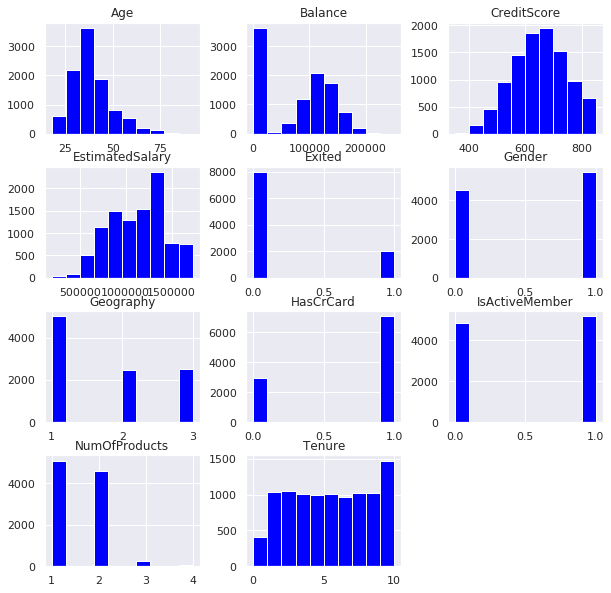

In [14]:
sns.set()
df_copy.hist(figsize=(10,10), color='blue')
plt.show()

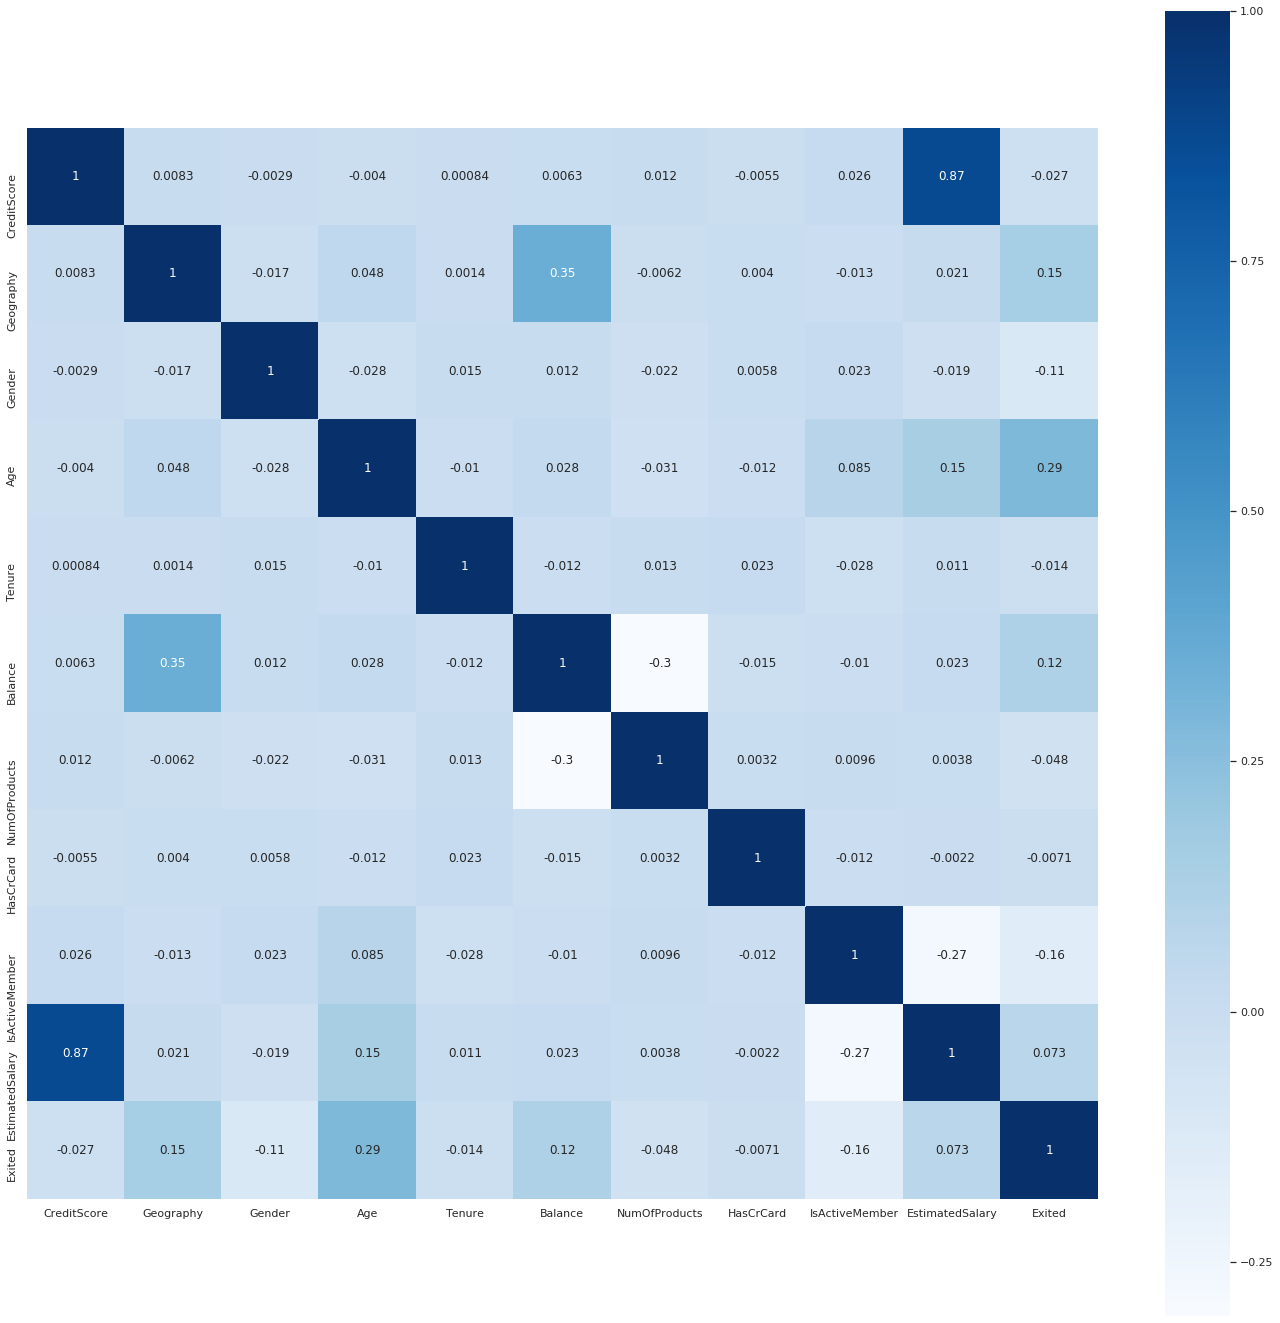

In [15]:
correlation = df_copy.corr()

import matplotlib.pyplot as plt
fig = plt.subplots(figsize=(24,24))
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap='Blues')

Cechy najsilniej skorelowane z 'exited' to:
    * Age (0.29)
    * IsActiveMember (-0.16)
    * Geography (0.15)
I ewentualnie:
    * Balance (0.12)
    * Gender (-0.11)
    
Czy wystepuja jakies korelacje miedzy nimi:
    * Balance & Geography (0.35) <- na to zwrocic uwage projektujac model

# Modele

In [16]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [17]:
from sklearn.linear_model import LogisticRegression

### RLog - Wszystkie zmienne

In [206]:
X = df_copy.drop('Exited', axis=1)
y = df_copy['Exited']

In [217]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [218]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.29,random_state=42, stratify=y)

In [21]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train.ravel())

/home/katarzyna/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
logreg_model.score(X_test, y_test)

0.7965517241379311

In [23]:
y_pred = logreg_model.predict(X_test)

In [24]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Logaritmic Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.20344827586206896
Mean Squared Logaritmic Error: 0.0977473373143927
Root Mean Squared Error: 0.45105240921878353


### RLog - Zmienne silniej skorelowane z 'Exited' 
(jedna para zmiennych objasniajacych ma korelacje 0.35)

In [25]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Balance', 'Gender']]
y = df_copy['Exited']

In [26]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [28]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train.ravel())

/home/katarzyna/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
logreg_model.score(X_test, y_test)

0.7965

In [30]:
y_pred = logreg_model.predict(X_test)

In [31]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Logaritmic Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2035
Mean Squared Logaritmic Error: 0.09777218833235397
Root Mean Squared Error: 0.4511097427455984


### RLog - Zmienne silniej skorelowane z 'Exited' 
(usuwam 'Balance' aby pozbyc sie korelacji miedzy zmiennymi objasniajacymi)

In [32]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Gender']]
y = df_copy['Exited']

In [33]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

In [35]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train.ravel())

/home/katarzyna/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
logreg_model.score(X_test, y_test)

0.8166666666666667

In [37]:
y_pred = logreg_model.predict(X_test)

In [38]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Logaritmic Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.18333333333333332
Mean Squared Logaritmic Error: 0.08808305255167026
Root Mean Squared Error: 0.4281744192888376


## Drzewo decyzyjne (DT)

In [39]:
from sklearn.tree import DecisionTreeClassifier

### DT - wszystkie zmienne

In [40]:
X = df_copy.drop('Exited', axis=1)
y = df_copy['Exited']

In [41]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.35,random_state=42, stratify=y)

In [43]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [44]:
dt_model.score(X_test, y_test)

0.7897142857142857

In [45]:
y_pred = dt_model.predict(X_test)

In [46]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Logaritmic Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2102857142857143
Mean Squared Logaritmic Error: 0.10103240521251321
Root Mean Squared Error: 0.45856920337688867


### DT - Zmienne silniej skorelowane z 'Exited' 
(jedna para zmiennych objasniajacych ma korelacje 0.35)

In [47]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Balance', 'Gender']]
y = df_copy['Exited']

In [48]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.31,random_state=42, stratify=y)

In [50]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [51]:
dt_model.score(X_test, y_test)

0.7903225806451613

In [52]:
y_pred = dt_model.predict(X_test)

In [53]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Logaritmic Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.20967741935483872
Mean Squared Logaritmic Error: 0.10074014807962287
Root Mean Squared Error: 0.4579054698896255


### DT - Zmienne silniej skorelowane z 'Exited' 
(usuwam 'Balance' aby pozbyc sie korelacji miedzy zmiennymi objasniajacymi)

In [54]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Gender']]
y = df_copy['Exited']

In [55]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.29,random_state=42, stratify=y)

In [57]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [58]:
dt_model.score(X_test, y_test)

0.8293103448275863

In [59]:
y_pred = dt_model.predict(X_test)

In [60]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Logaritmic Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1706896551724138
Mean Squared Logaritmic Error: 0.08200835927224472
Root Mean Squared Error: 0.41314604581481085


## Random Forest (RF)

In [61]:
from sklearn.ensemble import RandomForestClassifier

### RF - wszystkie zmienne

In [62]:
X = df_copy.drop('Exited', axis=1)
y = df_copy['Exited']

In [63]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [64]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

In [65]:
rf_model = RandomForestClassifier(n_estimators=27, random_state = 0)
rf_model.fit(X_train,y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=27,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [66]:
rf_model.score(X_test, y_test)

0.8583333333333333

In [67]:
y_pred = rf_model.predict(X_test)

In [68]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Logaritmic Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.14166666666666666
Mean Squared Logaritmic Error: 0.0680641769717452
Root Mean Squared Error: 0.3763863263545405


### RF - Zmienne silniej skorelowane z 'Exited' 
(jedna para zmiennych objasniajacych ma korelacje 0.35)

In [69]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Balance', 'Gender']]
y = df_copy['Exited']

In [70]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [71]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.31,random_state=42, stratify=y)

In [72]:
rf_model = RandomForestClassifier(n_estimators=10, random_state = 0)
rf_model.fit(X_train,y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [73]:
rf_model.score(X_test, y_test)

0.8151612903225807

In [74]:
y_pred = rf_model.predict(X_test)

In [75]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Logaritmic Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.18483870967741936
Mean Squared Logaritmic Error: 0.08880631515326755
Root Mean Squared Error: 0.4299287262761345


### RF - Zmienne silniej skorelowane z 'Exited' 
(usuwam 'Balance' aby pozbyc sie korelacji miedzy zmiennymi objasniajacymi)

In [76]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Gender']]
y = df_copy['Exited']

In [77]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.29,random_state=42, stratify=y)

In [79]:
rf_model = RandomForestClassifier(n_estimators=15, random_state = 0)
rf_model.fit(X_train,y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [80]:
rf_model.score(X_test, y_test)

0.8320689655172414

In [81]:
y_pred = rf_model.predict(X_test)

In [82]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Logaritmic Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.16793103448275862
Mean Squared Logaritmic Error: 0.08068297164764278
Root Mean Squared Error: 0.40979389268601674


## KNN

In [83]:
from sklearn.neighbors import KNeighborsClassifier

### KNN - wszystkie zmienne

In [84]:
X = df_copy.drop('Exited', axis=1)
y = df_copy['Exited']

In [85]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [86]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [87]:
test_scores = []
train_scores = []

for i in range(1,31):  

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train.ravel())
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [88]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [89]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 80.2 % and k = [19]


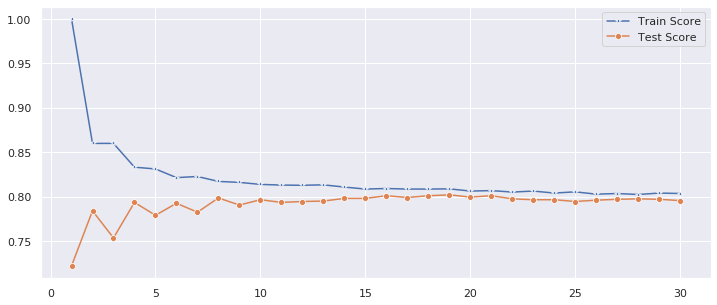

In [90]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,31),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,31),test_scores,marker='o',label='Test Score')

In [91]:
knn = KNeighborsClassifier(23)

knn.fit(X_train,y_train.ravel())
knn.score(X_test,y_test)

0.7965

In [92]:
y_pred = knn.predict(X_test)

In [93]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2035
Mean Squared Error: 0.2035
Root Mean Squared Error: 0.4511097427455984


### KNN - Zmienne silniej skorelowane z 'Exited' 
(jedna para zmiennych objasniajacych ma korelacje 0.35)

In [94]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Balance', 'Gender']]
y = df_copy['Exited']

In [95]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [96]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [97]:
test_scores = []
train_scores = []

for i in range(1,31):  

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train.ravel())
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [98]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 94.4875 % and k = [1]


In [99]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 80.45 % and k = [26]


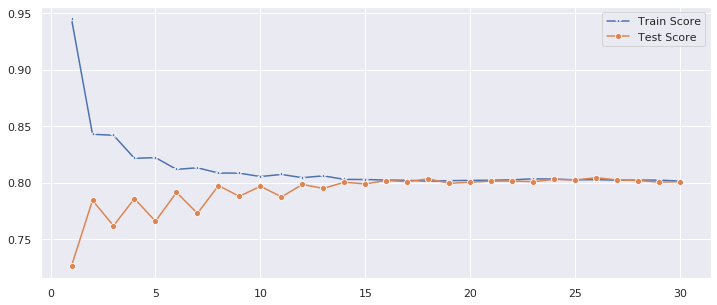

In [100]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,31),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,31),test_scores,marker='o',label='Test Score')

In [101]:
knn = KNeighborsClassifier(26)

knn.fit(X_train,y_train.ravel())
knn.score(X_test,y_test)

0.8045

In [102]:
y_pred = knn.predict(X_test)

In [103]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1955
Mean Squared Error: 0.1955
Root Mean Squared Error: 0.44215381938868287


### KNN - Zmienne silniej skorelowane z 'Exited' 
(usuwam 'Balance' aby pozbyc sie korelacji miedzy zmiennymi objasniajacymi)

In [104]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Gender']]
y = df_copy['Exited']

In [105]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [106]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [107]:
test_scores = []
train_scores = []

for i in range(1,31):  

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train.ravel())
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [108]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 84.15 % and k = [15]


In [109]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 83.35000000000001 % and k = [22]


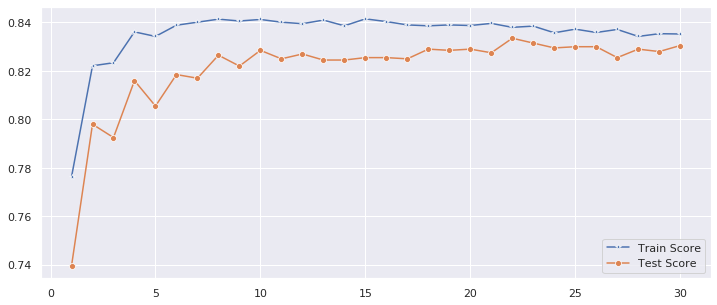

In [110]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,31),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,31),test_scores,marker='o',label='Test Score')

In [111]:
knn = KNeighborsClassifier(22)

knn.fit(X_train,y_train.ravel())
knn.score(X_test,y_test)

0.8335

In [112]:
y_pred = knn.predict(X_test)

In [113]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1665
Mean Squared Error: 0.1665
Root Mean Squared Error: 0.4080441152620633


## SVM

In [114]:
from sklearn import svm
from sklearn.svm import SVC

### SVM - wszystkie zmienne

In [115]:
X = df_copy.drop('Exited', axis=1)
y = df_copy['Exited']

In [116]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

Kernel liniowy

In [117]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=12, stratify=y)

In [118]:
linear_svm = svm.SVC(kernel='linear', random_state=12, C=5)
linear_svm.fit(X_train, y_train.ravel())

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=12,
    shrinking=True, tol=0.001, verbose=False)

In [119]:
linear_svm.score(X_train, y_train)

0.7758666666666667

In [120]:
y_pred = linear_svm.predict(X_test)

In [121]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2176
Mean Squared Error: 0.2176
Root Mean Squared Error: 0.466476151587624


Kernel RBF

In [122]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=12, stratify=y)

In [123]:
rbf_svm = svm.SVC(kernel='rbf',random_state=0, C=1)
rbf_svm.fit(X_train, y_train.ravel())

/home/katarzyna/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [124]:
rbf_svm.score(X_train, y_train)

0.986375

In [125]:
y_pred = rbf_svm.predict(X_test)

In [126]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.204
Mean Squared Error: 0.204
Root Mean Squared Error: 0.45166359162544856


### SVM - Zmienne silniej skorelowane z 'Exited' 
(jedna para zmiennych objasniajacych ma korelacje 0.35)

In [127]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Balance', 'Gender']]
y = df_copy['Exited']

In [128]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

Kernel liniowy

In [129]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [130]:
linear_svm = svm.SVC(kernel='linear', random_state=0, C=5)
linear_svm.fit(X_train, y_train.ravel())

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [131]:
linear_svm.score(X_train, y_train)

0.78275

In [132]:
y_pred = linear_svm.predict(X_test)

In [133]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.219
Mean Squared Error: 0.219
Root Mean Squared Error: 0.4679743582719036


Kernel RBF

In [134]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [135]:
rbf_svm = svm.SVC(kernel='rbf',random_state=0, C=150)
rbf_svm.fit(X_train, y_train.ravel())

/home/katarzyna/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=150, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [136]:
rbf_svm.score(X_train, y_train)

0.961875

In [137]:
y_pred = rbf_svm.predict(X_test)

In [138]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2015
Mean Squared Error: 0.2015
Root Mean Squared Error: 0.44888751374926883


### SVM - Zmienne silniej skorelowane z 'Exited' 
(usuwam 'Balance' aby pozbyc sie korelacji miedzy zmiennymi objasniajacymi)

In [139]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Gender']]
y = df_copy['Exited']

In [140]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

Kernel liniowy

In [141]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [142]:
linear_svm = svm.SVC(kernel='linear', random_state=0, C=5)
linear_svm.fit(X_train, y_train.ravel())

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [143]:
linear_svm.score(X_train, y_train)

0.79625

In [144]:
y_pred = linear_svm.predict(X_test)

In [145]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2035
Mean Squared Error: 0.2035
Root Mean Squared Error: 0.4511097427455984


Kernel RBF

In [146]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [147]:
rbf_svm = svm.SVC(kernel='rbf',random_state=0, C=150)
rbf_svm.fit(X_train, y_train.ravel())

/home/katarzyna/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=150, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [148]:
rbf_svm.score(X_train, y_train)

0.846875

In [149]:
y_pred = rbf_svm.predict(X_test)

In [150]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.178
Mean Squared Error: 0.178
Root Mean Squared Error: 0.4219004621945797


## BAYES

In [151]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

### BAYES - wszystkie zmienne

In [152]:
X = df_copy.drop('Exited', axis=1)
y = df_copy['Exited']

In [153]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [154]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [155]:
model = GaussianNB()
model.fit(X_train, y_train.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [156]:
model.score(X_test, y_test)

0.794

In [157]:
y_pred = model.predict(X_test)

In [158]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.22      0.00      0.01       407

    accuracy                           0.79      2000
   macro avg       0.51      0.50      0.45      2000
weighted avg       0.68      0.79      0.71      2000



In [159]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.206
Mean Squared Error: 0.206
Root Mean Squared Error: 0.4538722287164087


### BAYES - Zmienne silniej skorelowane z 'Exited' 
(jedna para zmiennych objasniajacych ma korelacje 0.35)

In [160]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Balance', 'Gender']]
y = df_copy['Exited']

In [161]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [162]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [163]:
model = GaussianNB()
model.fit(X_train, y_train.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [164]:
model.score(X_test, y_test)

0.79

In [165]:
y_pred = model.predict(X_test)

In [166]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1593
           1       0.41      0.08      0.13       407

    accuracy                           0.79      2000
   macro avg       0.61      0.52      0.50      2000
weighted avg       0.73      0.79      0.73      2000



In [167]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.21
Mean Squared Error: 0.21
Root Mean Squared Error: 0.458257569495584


### BAYES - Zmienne silniej skorelowane z 'Exited' 
(usuwam 'Balance' aby pozbyc sie korelacji miedzy zmiennymi objasniajacymi)

In [168]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Gender']]
y = df_copy['Exited']

In [169]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [170]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [171]:
model = GaussianNB()
model.fit(X_train, y_train.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [172]:
model.score(X_test, y_test)

0.811

In [173]:
y_pred = model.predict(X_test)

In [174]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.63      0.18      0.28       407

    accuracy                           0.81      2000
   macro avg       0.72      0.57      0.58      2000
weighted avg       0.78      0.81      0.77      2000



In [175]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.189
Mean Squared Error: 0.189
Root Mean Squared Error: 0.43474130238568315


## XG-BOOST

In [176]:
import xgboost as xgb

### XGB - wszystkie zmienne

In [177]:
X = df_copy.drop('Exited', axis=1)
y = df_copy['Exited']

In [178]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [179]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [180]:
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=123)
model.fit(X_train, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=1, verbosity=1)

In [181]:
model.score(X_test, y_test)

0.867

In [182]:
y_pred = model.predict(X_test)

In [183]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.48      0.59       407

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000



In [184]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.133
Mean Squared Error: 0.133
Root Mean Squared Error: 0.3646916505762094


### XGB - Zmienne silniej skorelowane z 'Exited' 
(jedna para zmiennych objasniajacych ma korelacje 0.35)

In [185]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Balance', 'Gender']]
y = df_copy['Exited']

In [186]:
X = pd.DataFrame(X).values
y = pd.DataFrame(y).values

In [187]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [188]:
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=123)
model.fit(X_train, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=1, verbosity=1)

In [189]:
model.score(X_test, y_test)

0.8365

In [190]:
y_pred = model.predict(X_test)

In [191]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1593
           1       0.71      0.33      0.45       407

    accuracy                           0.84      2000
   macro avg       0.78      0.65      0.68      2000
weighted avg       0.82      0.84      0.81      2000



In [192]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1635
Mean Squared Error: 0.1635
Root Mean Squared Error: 0.4043513323831146


### XGB - Zmienne silniej skorelowane z 'Exited' 
(usuwam 'Balance' aby pozbyc sie korelacji miedzy zmiennymi objasniajacymi)

In [193]:
X = df_copy[['Age','IsActiveMember', 'Geography', 'Gender']]
y = df_copy['Exited']

In [194]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [195]:
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=123)
model.fit(X_train, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=1, verbosity=1)

In [196]:
model.score(X_test, y_test)

0.833

In [197]:
y_pred = model.predict(X_test)

In [198]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1593
           1       0.70      0.31      0.43       407

    accuracy                           0.83      2000
   macro avg       0.77      0.64      0.67      2000
weighted avg       0.82      0.83      0.81      2000



In [199]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.167
Mean Squared Error: 0.167
Root Mean Squared Error: 0.408656334834051


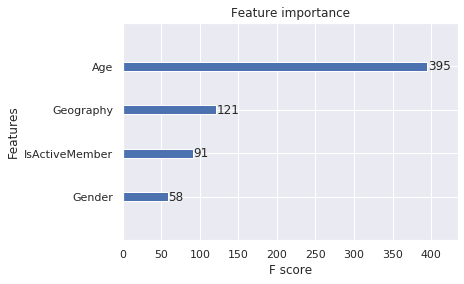

In [200]:
xgb.plot_importance(model)
plt.show()